## Bayesian Network

In this notebook, we develop a Bayesian Network to predict crime type with new categorical variables from the 911 call dataset, where assumptions in Navie Bayes are relaxed (prior knowledge of the conditional probability). As Prof suggested, we use the pomegranate package. Note that we have to install older version of basic packages such as numpy.



In [1]:
# !pip install pomegranate

In [2]:
from pomegranate import *
import numpy as np

### Example 1: Conditional probability is given

In [3]:
guest = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})
prize = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})
monty = ConditionalProbabilityTable(
        [['A', 'A', 'A', 0.0],
         ['A', 'A', 'B', 0.5],
         ['A', 'A', 'C', 0.5],
         ['A', 'B', 'A', 0.0],
         ['A', 'B', 'B', 0.0],
         ['A', 'B', 'C', 1.0],
         ['A', 'C', 'A', 0.0],
         ['A', 'C', 'B', 1.0],
         ['A', 'C', 'C', 0.0],
         ['B', 'A', 'A', 0.0],
         ['B', 'A', 'B', 0.0],
         ['B', 'A', 'C', 1.0],
         ['B', 'B', 'A', 0.5],
         ['B', 'B', 'B', 0.0],
         ['B', 'B', 'C', 0.5],
         ['B', 'C', 'A', 1.0],
         ['B', 'C', 'B', 0.0],
         ['B', 'C', 'C', 0.0],
         ['C', 'A', 'A', 0.0],
         ['C', 'A', 'B', 1.0],
         ['C', 'A', 'C', 0.0],
         ['C', 'B', 'A', 1.0],
         ['C', 'B', 'B', 0.0],
         ['C', 'B', 'C', 0.0],
         ['C', 'C', 'A', 0.5],
         ['C', 'C', 'B', 0.5],
         ['C', 'C', 'C', 0.0]], [guest, prize])

s1 = Node(guest, name="guest")
s2 = Node(prize, name="prize")
s3 = Node(monty, name="monty")

model = BayesianNetwork("Monty Hall Problem")
model.add_states(s1, s2, s3)
model.add_edge(s1, s3)
model.add_edge(s2, s3)
model.bake()

In [4]:
model.probability([['A', 'A', 'A'],
                             ['A', 'A', 'B'],
                             ['C', 'C', 'B']])

array([0.        , 0.05555556, 0.05555556])

In [5]:
#the calculation of the previous step
0.5/9

0.05555555555555555

In [6]:
print(model.predict([['A', 'A', None],
                         ['A', 'C', None],
                         ['C', 'B', None]]))

[array(['A', 'A', 'B'], dtype=object), array(['A', 'C', 'B'], dtype=object), array(['C', 'B', 'A'], dtype=object)]


### Example 2: Conditional probability is unknown

In [7]:
#Now we generate 2000 vectors of length 7
#And let the 2nd element == the 4rd element == 7th element,
#1st element == 3th element and 5th element == 6th element

X = numpy.random.randint(2, size=(2000, 7))
X[:,3] = X[:,1]
X[:,6] = X[:,1]
X[:,0] = X[:,2]
X[:,4] = X[:,5]

model = BayesianNetwork.from_samples(X, algorithm='exact')
print(model.structure)

((), (), (0,), (1,), (), (4,), (3,))


In [8]:
X[:10]

array([[0, 1, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0],
       [1, 0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 0, 0, 1],
       [1, 1, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1]])

In [9]:
model.predict([[0, 1, 0, 1, None, None, None]])

[array([0, 1, 0, 1, 0, 0, 1], dtype=object)]

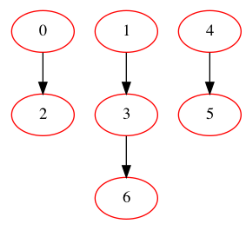

In [10]:
model.plot()

### 3. Crimes w/ 911 calls w/o demographic

In [2]:
import pandas as pd
from pomegranate import *
import numpy as np

In [3]:
df = pd.read_csv("crimes_with_calls_2015_unique_demographics.csv", index_col=0)

In [4]:
df.head(3)

,Unnamed: 0.1,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,...,perc18_24,perc25_64,perc65up,perc_asian,perc_aa,perc_hisp,perc_white,median_price_homes_sold,racial_diversity_index,num_households
0,131273,2015-01-01 00:00:00,22:15:00,6D,1200 RAMBLEWOOD RD,LARCENY FROM AUTO,O,NaN,414.0,NORTHEASTERN,...,11.921491,52.830846,13.559027,1.190407,90.029615,1.753673,6.474653,104400.0,20.416364,104400.0
1,131278,2015-01-01 00:00:00,21:00:00,6D,5800 BLAND AV,LARCENY FROM AUTO,O,NaN,632.0,NORTHWESTERN,...,7.457510,50.242803,17.799746,2.058041,61.804833,5.746329,26.904844,63500.0,57.696904,102600.0
2,131281,2015-01-01 00:00:00,21:00:00,7C,300 S CONKLING ST,AUTO THEFT,O,NaN,231.0,SOUTHEASTERN,...,6.926070,55.739300,12.373541,1.945525,14.250973,31.887160,45.846304,84950.0,75.564709,88000.0


In [5]:
df = df[['Inside/Outside', "District","Neighborhood","Premise","Priority","CallDescription","Description"]]
df.isna().sum()

Inside/Outside     71
District            0
Neighborhood        0
Premise            87
Priority           69
CallDescription     0
Description         0
dtype: int64

In [6]:
df = df.dropna().reset_index(drop=True)
df.head(3)

,Inside/Outside,District,Neighborhood,Premise,Priority,CallDescription,Description
0,O,NORTHEASTERN,RAMBLEWOOD,STREET,Low,Larceny f/Auto,LARCENY FROM AUTO
1,O,NORTHWESTERN,GLEN,STREET,Low,Larceny f/Auto,LARCENY FROM AUTO
2,O,SOUTHEASTERN,HIGHLANDTOWN,STREET,Medium,Auto Theft,AUTO THEFT


In [7]:
df['Inside/Outside'] = df['Inside/Outside'].replace('I', 'Inside')
df['Inside/Outside'] = df['Inside/Outside'].replace('O', 'Outside')

Borrowed Marek's cleaning code on Premise and CallDescription. Added a few more for CallDescription.

In [8]:
df['Premise'] = df['Premise'].str.upper()

# Premise Modifications

df['Premise'] = df['Premise'].replace('GARAGE ON', 'SHED/GARAGE')
df['Premise'] = df['Premise'].replace('APT. LOCKE', 'APARTMENT')
df['Premise'] = df['Premise'].replace('APT/CONDO', 'APARTMENT')
df['Premise'] = df['Premise'].replace('COMMON BUS', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('HOSP/NURS.', 'HOSPITAL')
df['Premise'] = df['Premise'].replace('VEHICLE', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('PRIVATE SC', 'SCHOOL')
df['Premise'] = df['Premise'].replace('PUBLIC SCH', 'SCHOOL')
df['Premise'] = df['Premise'].replace('TAVERN/NIG', 'BAR')
df['Premise'] = df['Premise'].replace('RAILROAD C', 'BUS/RAILRO')
df['Premise'] = df['Premise'].replace('COMMON BUS', 'BUS/AUTO')
df['Premise'] = df['Premise'].replace('CHURCH', 'RELIGIOUS')
df['Premise'] = df['Premise'].replace('ARENA', 'STADIUM')
df['Premise'] = df['Premise'].replace('YARD/BUSIN', 'YARD')
df['Premise'] = df['Premise'].replace('PIZZA/OTHE', 'RESTAURANT')
df['Premise'] = df['Premise'].replace('DAY CARE F', 'SCHOOL PLA')
df['Premise'] = df['Premise'].replace('MANUFACTUR', 'WAREHOUSE')
df['Premise'] = df['Premise'].replace('MOBILE HOM', 'DWELLING')
df['Premise'] = df['Premise'].replace('BOX CARS/C', 'BUS/RAILRO')
df['Premise'] = df['Premise'].replace('PHOTO STUD', 'RETAIL/SMA')
df['Premise'] = df['Premise'].replace('TRUCKING &', 'TRACTOR TR')
df['Premise'] = df['Premise'].replace('SKYWALK', 'PUBLIC ARE')
df['Premise'] = df['Premise'].replace('FINANCE/LO', 'BANK/FINAN')
df['Premise'] = df['Premise'].replace('STRUCTURE-', 'UNKNOWN')
df['Premise'] = df['Premise'].replace('BLDG UNDER', 'CONSTRUCTI')
df['Premise'] = df['Premise'].replace('HOUSE UNDE', 'CONSTRUCTI')
df['Premise'] = df['Premise'].replace('MAILBOX-ST', 'STREET')
df['Premise'] = df['Premise'].replace('RENTAL/VID', 'RETAIL/SMA')

In [9]:
df["Description"].unique()

array(['LARCENY FROM AUTO', 'AUTO THEFT', 'BURGLARY',
       'ROBBERY - COMMERCIAL', 'LARCENY', 'SHOOTING', 'AGG. ASSAULT',
       'COMMON ASSAULT', 'ROBBERY - RESIDENCE', 'ROBBERY - STREET',
       'ROBBERY - CARJACKING', 'HOMICIDE', 'ASSAULT BY THREAT', 'ARSON',
       'RAPE'], dtype=object)

In [10]:
df["CallDescription"] = df['CallDescription'].str.upper()
df = df[df["CallDescription"]!= "`"]
df = df[df["CallDescription"]!= "911/HANGUP"]
df = df[df["CallDescription"]!= "911/NO VOICE"]
df["CallDescription"] = df["CallDescription"].str.replace("*","")
df['CallDescription'] = df['CallDescription'].replace('AUTO ACC/INJURY', 'AUTO ACCIDENT')
df['CallDescription'] = df['CallDescription'].replace('AED NONBREATHIG', 'AED NONBREATHING')
df['CallDescription'] = df['CallDescription'].replace('ASSIST', 'ASSISTANCE')
df['CallDescription'] = df['CallDescription'].replace('ATTEMPT', 'ATTEMPTED')
df['CallDescription'] = df['CallDescription'].replace('ATTEMTED', 'ATTEMPTED')
df['CallDescription'] = df['CallDescription'].replace('ATTMPT BURGLARY', 'ATTEMPTED THEFT')
df['CallDescription'] = df['CallDescription'].replace('BAIL OUT', 'BAILOUT')
df['CallDescription'] = df['CallDescription'].replace('BY THREATS', 'BY THREAT')
df['CallDescription'] = df['CallDescription'].replace('CHECK WELL BEIN', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHECKWELLBEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHEK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CHK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CK WELL BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('CK WELL-BEING', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('WELL BEING CHECK', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('WELLBEING CHECK', 'CHECK WELLBEING')
df['CallDescription'] = df['CallDescription'].replace('EXPARTE', 'EX PARTE')
df['CallDescription'] = df['CallDescription'].replace('FOLLOW UP', 'FOLLOW-UP')
df['CallDescription'] = df['CallDescription'].replace('FOOT  PATROL', 'FOOT PATROL')
df['CallDescription'] = df['CallDescription'].replace('GET   BELONGINGS', 'GET BELONGINGS')
df['CallDescription'] = df['CallDescription'].replace('GET BELONINGS', 'GET BELONGINGS')
df['CallDescription'] = df['CallDescription'].replace('INVEST', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST TRB', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST TROUBLE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVEST.', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTGATE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTIGTE', 'INVESTIGATE')
df['CallDescription'] = df['CallDescription'].replace('INVESTIG AUTO', 'INVESTIGATE AUTO')
df['CallDescription'] = df['CallDescription'].replace('LARCENCY', 'LARCENY')
df['CallDescription'] = df['CallDescription'].replace('OUT OF JURIS', 'OUT OF JURISDC')
df['CallDescription'] = df['CallDescription'].replace('POLICE ASSIT', 'POLICE ASSIST')
df['CallDescription'] = df['CallDescription'].replace('POLICE INFOR', 'POLICE INFO')
df['CallDescription'] = df['CallDescription'].replace('POLICE INFORMAT', 'POLICE ASSIST')
df['CallDescription'] = df['CallDescription'].replace('POSS', 'POSSIBLE')
df['CallDescription'] = df['CallDescription'].replace('PROT ORDER', 'PROTECTIVE ORDER')
df['CallDescription'] = df['CallDescription'].replace('PROTECT ORDER', 'PROTECTIVE ORDER')
df['CallDescription'] = df['CallDescription'].replace('SEARCH& SEIZURE', 'SEARCH&SEIZURE')
df['CallDescription'] = df['CallDescription'].replace('UNAUTHOR USE', 'UNAUTHORIZED USE')
df['CallDescription'] = df['CallDescription'].replace('UNKNOWN TROUBLE', 'UNKNOWN PROBLEM')

In [11]:
df['Priority'] = df['Priority'].str.upper()
df['Priority'] = df['Priority'].replace('EMERGENCY', 'HIGH')

In [12]:
df.describe()

,Inside/Outside,District,Neighborhood,Premise,Priority,CallDescription,Description
count,9092,9092,9092,9092,9092,9092,9092
unique,2,9,270,80,5,141,15
top,Outside,SOUTHEASTERN,DOWNTOWN,STREET,LOW,LARCENY F/AUTO,LARCENY
freq,5304,1479,332,4313,3869,1825,2164


In [13]:
train = df.iloc[:8000]
test = df.iloc[8000:]

In [14]:
train_array = train.to_numpy()
test_array = test.to_numpy()

## MODELS

In [ ]:
#kernel dies every time with algorithm='exact'

#These results show that the exact-dp algorithm is both computationally faster
#and requires far less memory than the traditional exact algorithm,
# making it a better default for the 'exact' algorithm.
# The amount of memory used by the BNSL process is under 'increment',
# not 'peak memory', as 'peak memory' returns the total memory used by everything, 
# while increment shows the difference in peak memory before and after the function has run.

#However, still slow with our dataset.

model = BayesianNetwork.from_samples(train_array, algorithm='exact-dp')
print(model.structure)

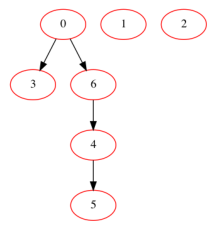

In [95]:
model.plot()

In [67]:
train_array = train_array[:1500]
test_array = test.to_numpy()

In [16]:
#however, exact-dp is still slow for our dataset
#let us try some heuristics

#SUPER FAST with Chow-Liu Approximation
model1 = BayesianNetwork.from_samples(train_array, algorithm='chow-liu')
print(model1.structure)

((), (2,), (3,), (0,), (5,), (2,), (5,))


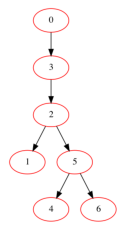

In [18]:
model1.plot()

In [68]:
#Greedy
model2 = BayesianNetwork.from_samples(train_array, algorithm='greedy')
print(model2.structure)

((), (), (), (0,), (0,), (4,), (0, 4))


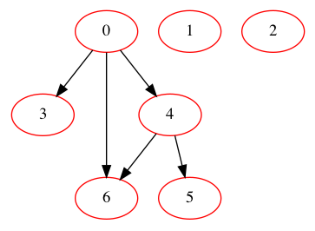

In [69]:
model2.plot()

In [31]:
test_array[1]

array(['Inside', 'EASTERN', 'EAST BALTIMORE MIDWAY', 'RETAIL/SMA', 'LOW',
       'LARCENY', 'LARCENY'], dtype=object)

In [34]:
model1.predict([['Inside', 'EASTERN', 'EAST BALTIMORE MIDWAY', 'RETAIL/SMA', 'LOW',
       'LARCENY', None]])

[array(['Inside', 'EASTERN', 'EAST BALTIMORE MIDWAY', 'RETAIL/SMA', 'LOW',
        'LARCENY', 'LARCENY'], dtype=object)]

In [104]:
test.tail(5)

,Inside/Outside,District,Neighborhood,Premise,Priority,CallDescription,Description
9114,Outside,SOUTHERN,HOLLINS MARKET,STREET,LOW,LARCENY F/AUTO,LARCENY FROM AUTO
9115,Outside,SOUTHEASTERN,BAYVIEW,STREET,LOW,OTHER,AGG. ASSAULT
9116,Inside,SOUTHEASTERN,LITTLE ITALY,ROW/TOWNHO,LOW,LARCENY,BURGLARY
9117,Outside,SOUTHEASTERN,LITTLE ITALY,STREET,LOW,LARCENY F/AUTO,LARCENY FROM AUTO
9118,Outside,NORTHEASTERN,FRANKFORD,STREET,HIGH,ROBBERY ARMED,ROBBERY - STREET


In [99]:
test.head(1)

,Inside/Outside,District,Neighborhood,Premise,Priority,CallDescription,Description
9082,Inside,SOUTHEASTERN,HIGHLANDTOWN,ROW/TOWNHO,MEDIUM,DISORDERLY,BURGLARY


In [91]:
#predict target variable
model2.predict([['Inside', 'SOUTHEASTERN', 'HIGHLANDTOWN', 'ROW/TOWNHO', 'MEDIUM',
       'DISORDERLY', None]])

[array(['Inside', 'SOUTHEASTERN', 'HIGHLANDTOWN', 'ROW/TOWNHO', 'MEDIUM',
        'DISORDERLY', 'BURGLARY'], dtype=object)]

In [103]:
#impute missing feature
model2.predict([['Inside', 'SOUTHEASTERN', 'HIGHLANDTOWN', 'ROW/TOWNHO', None,
       'DISORDERLY', None]])

[array(['Inside', 'SOUTHEASTERN', 'HIGHLANDTOWN', 'ROW/TOWNHO', 'MEDIUM',
        'DISORDERLY', 'BURGLARY'], dtype=object)]

In [40]:
#prediction is slow
#let's try the first 100 observations in the test set

test_pred = []

for i in range(100):
    test_pred.append(model1.predict([test_features[i]]))

In [35]:
test_features = [np.append(arr[:-1],[None]) for arr in test_array]

In [48]:
test_pred[i]

[array(['Outside', 'SOUTHERN', 'HOLLINS MARKET', 'ALLEY', 'LOW',
        'LARCENY F/AUTO', 'LARCENY FROM AUTO'], dtype=object)]

In [51]:
accuracy = sum([test_pred[i][0][-1] == test_array[i][-1] for i in range(100)])/100
print("Accuracy: {}".format(accuracy))

Accuracy: 0.67
